<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/VGG2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

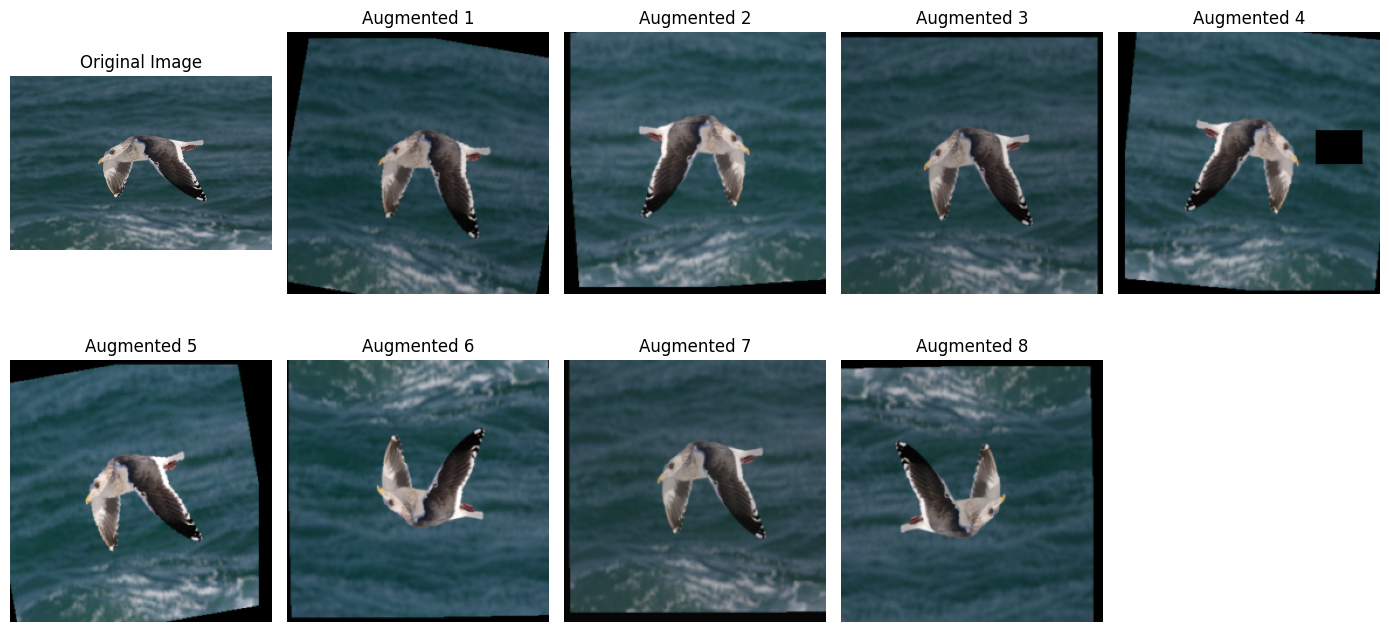

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Set dataset path (Update this if needed)
dataset_path = "/content/drive/My Drive/FYP/Dataset/HQ3/train"

# Select a random class folder from dataset
class_folder = random.choice(os.listdir(dataset_path))
class_path = os.path.join(dataset_path, class_folder)

# Select a random image from that class
image_file = random.choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_file)

# Load the image
original_image = Image.open(image_path)

# Define Augmentations (NO MORE BLUR!)
pil_transforms = transforms.Compose([
    transforms.Resize((300, 300)),  # Instead of 224x224, use 256x256  # Resize to match VGG input
    transforms.RandomHorizontalFlip(p=0.5),  # Flip left/right
    transforms.RandomVerticalFlip(p=0.3),  # Flip up/down (not too often)
    transforms.RandomRotation(degrees=10),  # Slight rotations to simulate natural variations (was 15)
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Minor translation to shift position (reduced from 0.1)
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Very slight color variations (reduced from 0.2)
    transforms.RandomResizedCrop(224, scale=(0.95, 1.0)),  # Less aggressive cropping (previously 0.85)
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.3),  # Keep mild sharpness (was 1.5)
])

# Convert to Tensor and Apply Tensor-Specific Transformations
tensor_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.05)),  # Reduce small area removal (was 0.2)
])

# Generate augmented versions of the image
num_augmentations = 8  # Number of different augmentations to display
augmented_images = []
for _ in range(num_augmentations):
    img = pil_transforms(original_image)  # Apply PIL-based augmentations
    img = tensor_transforms(img)  # Convert to tensor and apply tensor-based transforms
    augmented_images.append(img)

# Convert tensors back to PIL for visualization
augmented_images = [transforms.ToPILImage()(img) for img in augmented_images]

# Display original vs. augmented images
plt.figure(figsize=(14, 7))
plt.subplot(2, num_augmentations//2 + 1, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

for i, aug_img in enumerate(augmented_images):
    plt.subplot(2, num_augmentations//2 + 1, i+2)
    plt.imshow(aug_img)
    plt.title(f"Augmented {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch [1/20], Loss: 0.364264
Validation Accuracy: 78.95%
Current model saved at /content/drive/My Drive/FYP/VGGModel/Improved_20250210/current_model_vgg_improved.pth
New best model saved with accuracy: 78.95% at /content/drive/My Drive/FYP/VGGModel/Improved_20250210/best_model_vgg_improved_20250210.pth
Epoch [2/20], Loss: 0.145260
Validation Accuracy: 94.74%
Current model saved at /content/drive/My Drive/FYP/VGGModel/Improved_20250210/current_model_vgg_improved.pth
New best model saved with accuracy: 94.74% at /content/drive/My Drive/FYP/VGGModel/Improved_20250210/best_model_vgg_improved_20250210.pth
Epoch [3/20], Loss: 0.070149
Validation Accuracy: 94.74%
Current model saved at /content/drive/My Drive/FYP/VGGModel/Improved_20250210/current_model_vgg_improved.pth
Epoch [4/20], Loss: 0.048459
Validation Accuracy: 94.74%
Current model saved a

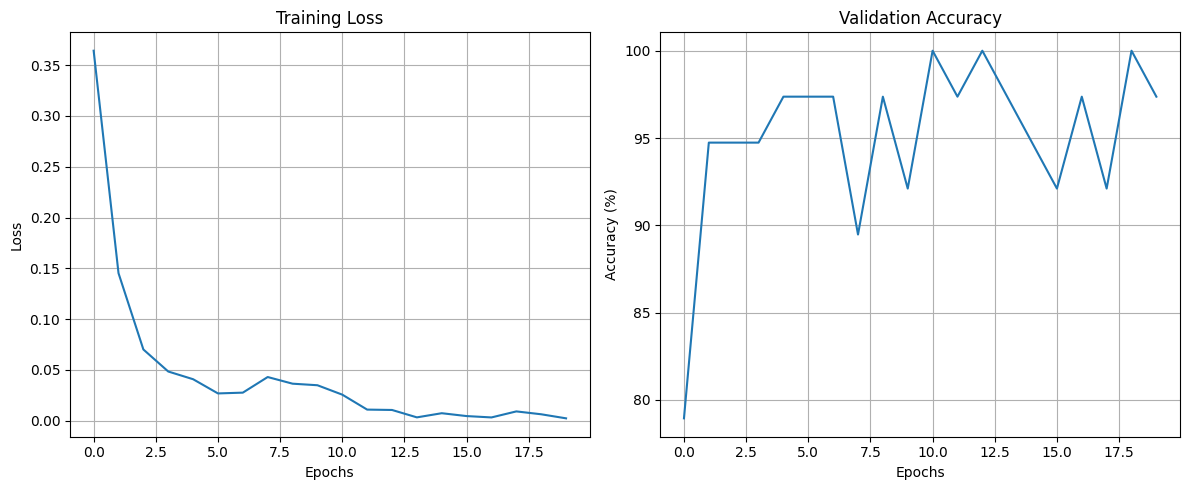

Final model saved at /content/drive/My Drive/FYP/VGGModel/Improved_20250210/final_model_vgg_improved_20250210.pth
Test Loss: 0.154089, Test Accuracy: 92.31%


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
date_str = datetime.now().strftime('%Y%m%d')
checkpoint_folder = f'/content/drive/My Drive/FYP/VGGModel/Improved_{date_str}/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
# Define Augmentations for Training Set (Keeping Image at 300x300)
transform_train = transforms.Compose([
    transforms.Resize((300, 300)),  # Change input size to 300x300
    transforms.RandomHorizontalFlip(p=0.5),  # Flip left/right
    transforms.RandomVerticalFlip(p=0.3),  # Flip up/down (not too often)
    transforms.RandomRotation(degrees=10),  # Small rotation (preserves structure)
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Slight shifts
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Small color changes
    transforms.RandomResizedCrop(300, scale=(0.95, 1.0)),  # Crop slightly (keeps structure)
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.3),  # Enhance details slightly
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Standard normalization
])

# Define Augmentations for Validation & Test Set (No aggressive modifications)
transform_val_test = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize to match training size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Keep normalization same as training
])

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQ3/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQ3/test'
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 95% training and 5% validation
train_size = int(0.95 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#######################################
# Define a simple Squeeze-and-Excitation (SE) block for channel attention
#######################################
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

#######################################
# Improved VGG-16 model with custom classifier and attention module
#######################################
class VGG16Improved(nn.Module):
    def __init__(self, num_classes=2, freeze_layers=True):
        super(VGG16Improved, self).__init__()
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # Optionally freeze early layers
        if freeze_layers:
            for param in self.vgg.features[:24].parameters():
                param.requires_grad = False

        self.attention = SEBlock(channel=512, reduction=16)

        # Pass a dummy input through features to determine the flattened size
        dummy = torch.zeros(1, 3, 300, 300)
        dummy = self.vgg.features(dummy)
        # Option 1: Use AdaptiveAvgPool2d to force a fixed shape
        dummy = nn.AdaptiveAvgPool2d((7, 7))(dummy)
        flattened_size = dummy.view(1, -1).size(1)  # Should be 25088

        # Replace the classifier with a custom one using the computed flattened_size
        self.vgg.classifier = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.vgg.features(x)
        x = self.attention(x)
        # Optionally use adaptive pooling here as well (if not computed dynamically)
        x = nn.AdaptiveAvgPool2d((7, 7))(x)
        x = x.view(x.size(0), -1)
        x = self.vgg.classifier(x)
        return x

# Initialize the improved VGG model
model = VGG16Improved(num_classes=2, freeze_layers=True).to(device)

# Define loss function and optimizer (only update parameters with requires_grad=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

#######################################
# Training loop with learning rate scheduler
# The code saves the current model every epoch (overwriting the previous saved model)
# and also saves a separate file if the model has a new best validation accuracy.
#######################################
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    best_acc = 0.0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.6f}")

        # Validate the model
        val_acc = validate(model, val_loader, criterion)
        val_accuracies.append(val_acc)
        scheduler.step(val_acc)

        # Save the current epoch's model (overwrite previous saved model)
        current_model_path = os.path.join(checkpoint_folder, "current_model_vgg_improved.pth")
        torch.save(model.state_dict(), current_model_path)
        print(f"Current model saved at {current_model_path}")

        # Save the best model (if current epoch improved validation accuracy)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_path = os.path.join(checkpoint_folder, f"best_model_vgg_improved_{date_str}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {best_acc:.2f}% at {best_model_path}")

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Finally, save the model from the last epoch as the final model
    final_model_path = os.path.join(checkpoint_folder, f"final_model_vgg_improved_{date_str}.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")

#######################################
# Validation loop returning accuracy
#######################################
def validate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return accuracy

#######################################
# Test function to evaluate on the test set
#######################################
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(loader):.6f}, Test Accuracy: {accuracy:.2f}%')

#######################################
# Step 1: Train the improved model with learning rate scheduling
#######################################
train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

#######################################
# Step 2: Evaluate the model on the test set
#######################################
test(model, test_loader, criterion)
